In [1]:
import sys as _sys
import warnings as _wrn
import numpy as _nmp
import numpy.random as _rnd
import matplotlib.pyplot as _plt
import pandas as _pnd

%load_ext autoreload
%autoreload 2
%matplotlib inline

_wrn.filterwarnings('always')
_plt.style.use('ggplot')

In [3]:
import eQTLseq as _assoc

Fitting gene 12612 of 12613
540 genes did not converge
/Users/dimitris/VEnvs/py35/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/dimitris/VEnvs/py35/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


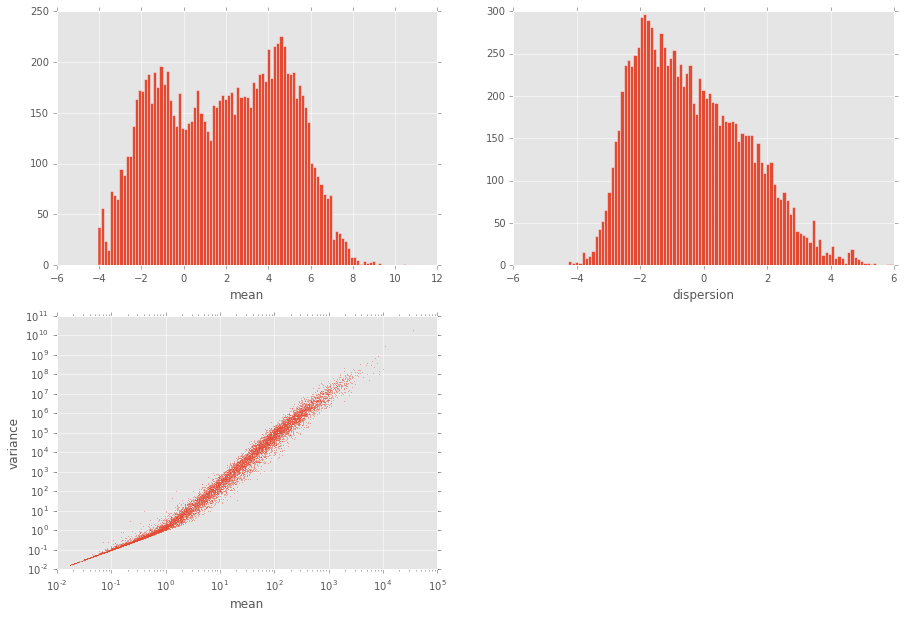

In [4]:
def fcn(fname):
    counts_CEU = _pnd.read_table(fname, index_col=0).values
    counts_CEU = counts_CEU[counts_CEU.sum(1)>0, :]  # remove zero-sum rows
    fit = _assoc.fit_nbinom_model(counts_CEU)
    print('{} genes did not converge'.format((~fit['converged']).sum()), file=_sys.stderr)
    idxs = (fit['converged']) & (_nmp.log(fit['phi']) > -10)
    pars = {'mu': fit['mu'][idxs], 'phi': fit['phi'][idxs]}
    
    return pars

##
pars = fcn('data/montpick_count_table_CEU.txt')

_plt.figure(figsize=(15,10))
_plt.subplot(2,2,1); _plt.hist(_nmp.log(pars['mu']), 100); _plt.xlabel('mean')
_plt.subplot(2,2,2); _plt.hist(_nmp.log(pars['phi']), 100); _plt.xlabel('dispersion');
_plt.subplot(2,2,3); _plt.loglog(pars['mu'], pars['mu'] + pars['mu']**2 / pars['phi'], '.', markersize=0.5); _plt.xlabel('mean'); _plt.ylabel('variance');

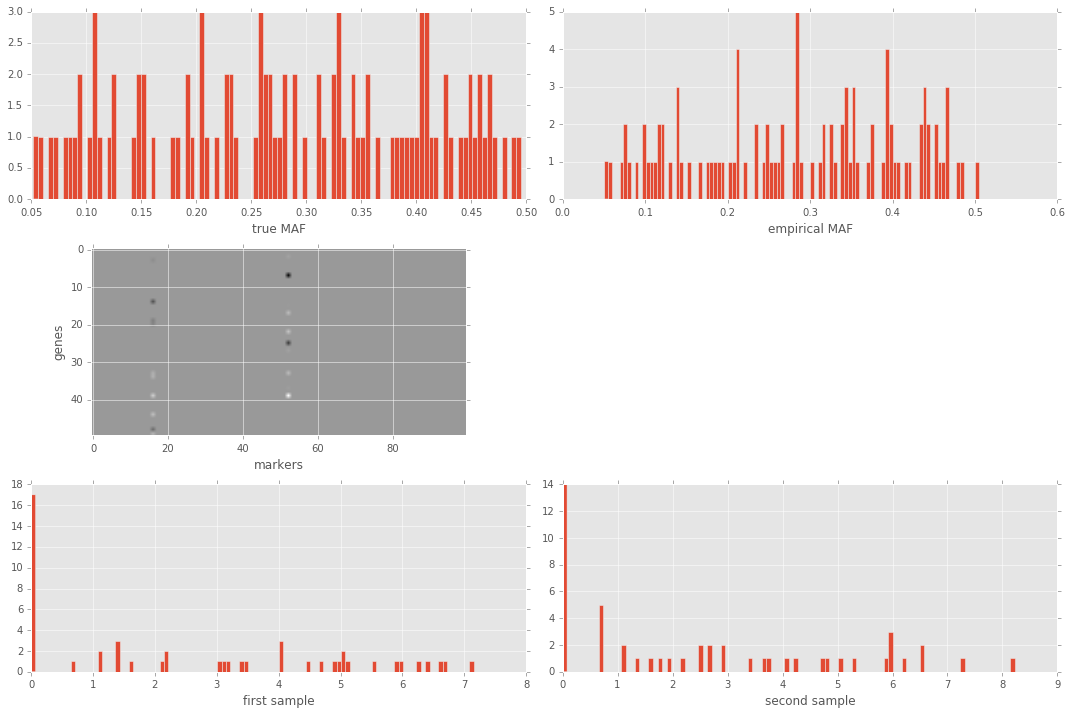

In [35]:
def fcn(n_samples, n_markers, n_markers_causal, n_genes, n_genes_affected, MAF_range):
    data_geno = _assoc.simulate_genotypes(n_samples, n_markers, MAF_range)
    data_pheno = _assoc.simulate_phenotypes(data_geno['G'], pars['mu'], pars['phi'], mdl='NBinom', n_markers_causal=n_markers_causal, n_genes=n_genes, n_genes_affected=n_genes_affected, h2=0.5)

    _plt.figure(figsize = (15,10));
    _plt.subplot(3,2,1); _plt.hist(data_geno['MAF'], 100); _plt.xlabel('true MAF')
    _plt.subplot(3,2,2); _plt.hist(data_geno['G'].sum(0) / (2 * n_samples), 100); _plt.xlabel('empirical MAF')
    _plt.subplot(3,2,3); _plt.imshow(data_pheno['coefs'], cmap=_plt.cm.gray); _plt.xlabel('markers'); _plt.ylabel('genes')
#     _plt.subplot(3,2,4); _plt.loglog(data_pheno['mu'], data_pheno['mu'] + data_pheno['mu']**2 / data_pheno['phi'], '.'); _plt.xlabel('mean'); _plt.ylabel('variance');
    _plt.subplot(3,2,5); _plt.hist(_nmp.log(data_pheno['Z'][0,:]+1), 100); _plt.xlabel('first sample');
    _plt.subplot(3,2,6); _plt.hist(_nmp.log(data_pheno['Z'][1,:]+1), 100); _plt.xlabel('second sample');
    _plt.tight_layout()
    
    return data_geno, data_pheno

##
data_geno, data_pheno = fcn(n_samples = 1000,
                            n_markers = 100, n_markers_causal = 2,
                            n_genes = 50, n_genes_affected = 10,
                            MAF_range = [0.05, 0.5])

In [36]:
loglik1, estim1 = _assoc.run(data_pheno['Y'], data_geno['G'], n_iters = 1000)

Iteration 1000 of 1000
Done!


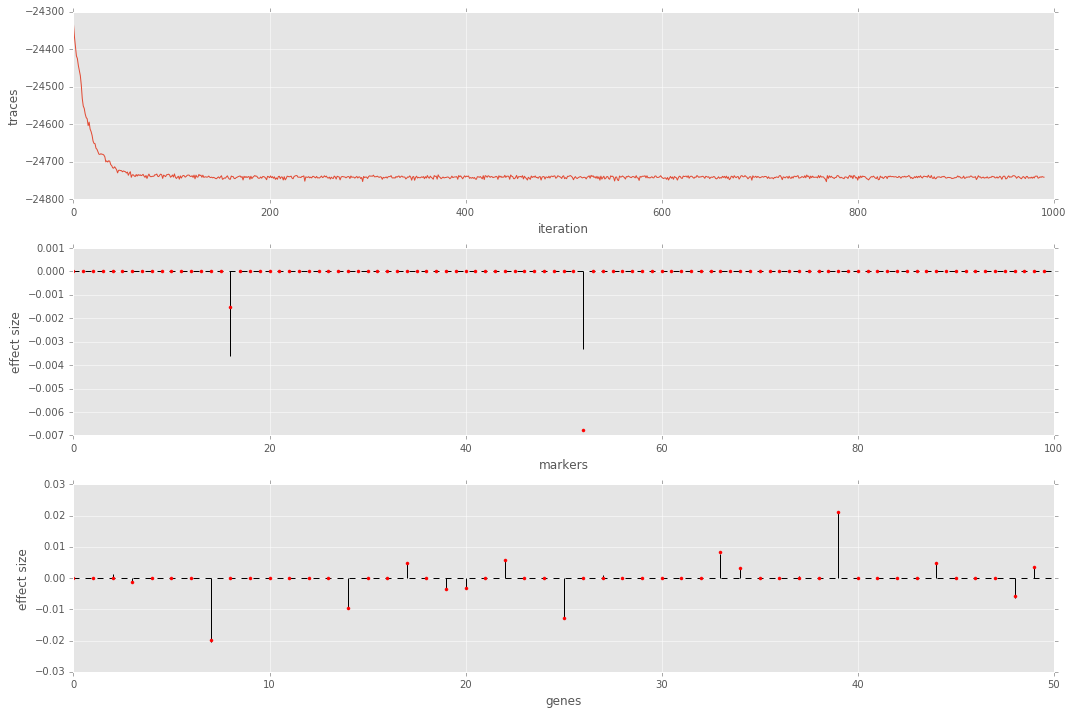

In [37]:
_plt.figure(figsize = (15,10));
_plt.subplot(3,1,1); _plt.plot(loglik1[10:]); _plt.xlabel('iteration'); _plt.ylabel('traces')

_plt.subplot(3,1,2); 
_plt.vlines(range(data_pheno['coefs'].shape[1]), 0, _nmp.mean(data_pheno['coefs'], 0)); 
_plt.axhline(linestyle='--', color='k');
_plt.plot(_nmp.mean(estim1['beta'], 0), 'r.'); _plt.xlabel('markers'); _plt.ylabel('effect size')

_plt.subplot(3,1,3); 
_plt.vlines(range(data_pheno['coefs'].shape[0]), 0, _nmp.mean(data_pheno['coefs'], 1)); 
_plt.axhline(linestyle='--', color='k');
_plt.plot(_nmp.mean(estim1['beta'], 1), 'r.'); _plt.xlabel('genes'); _plt.ylabel('effect size')

_plt.tight_layout()

In [40]:
loglik2, estim2 = _assoc.run(data_pheno['Z'], data_geno['G'], mdl = 'Binom', n_iters = 1000, mu = data_pheno['mu'], YY=data_pheno['Y'])

Iteration 1000 of 1000
Done!


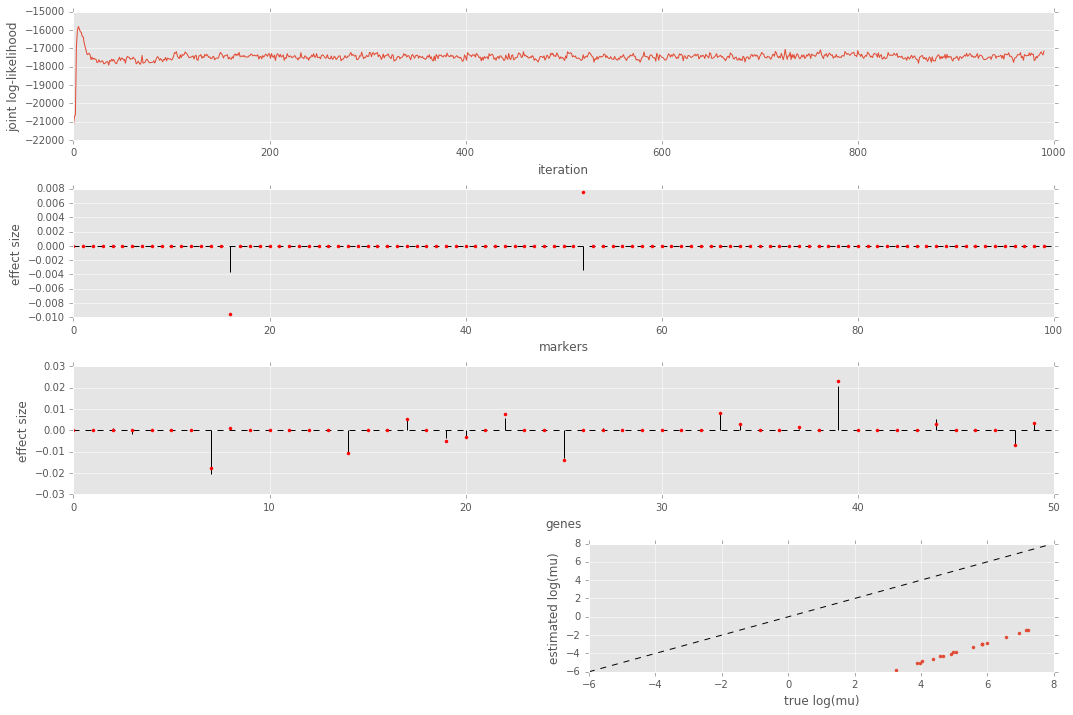

In [41]:
_plt.figure(figsize = (15,10));
_plt.subplot(4,1,1); _plt.plot(loglik2[10:]); _plt.xlabel('iteration'); _plt.ylabel('joint log-likelihood')

_plt.subplot(4,1,2); 
_plt.vlines(range(data_pheno['coefs'].shape[1]), 0, _nmp.mean(data_pheno['coefs'], 0)); 
_plt.axhline(linestyle='--', color='k');
_plt.plot(_nmp.mean(estim2['beta'], 0), 'r.'); _plt.xlabel('markers'); _plt.ylabel('effect size')

_plt.subplot(4,1,3); 
_plt.vlines(range(data_pheno['coefs'].shape[0]), 0, _nmp.mean(data_pheno['coefs'], 1)); 
_plt.axhline(linestyle='--', color='k');
_plt.plot(_nmp.mean(estim2['beta'], 1), 'r.'); _plt.xlabel('genes'); _plt.ylabel('effect size')

_plt.subplot(4,2,8); 
_plt.plot(_nmp.log(data_pheno['mu']), _nmp.log(estim2['mu']), '.'); _plt.ylim(_plt.xlim()); 
_plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
_plt.xlabel('true log(mu)'); _plt.ylabel('estimated log(mu)')

_plt.tight_layout()

In [ ]:
loglik3, estim3 = _assoc.run(data_pheno['Z'], data_geno['G'], mdl = 'NBinom', n_iters = 1000, mu = data_pheno['mu'], YY=data_pheno['Y'])

In [ ]:
_plt.figure(figsize = (15,10));
_plt.subplot(4,1,1); _plt.plot(loglik3[100:]); _plt.xlabel('iteration'); _plt.ylabel('joint log-likelihood')

_plt.subplot(4,1,2); 
_plt.vlines(range(data_pheno['coefs'].shape[1]), 0, _nmp.mean(data_pheno['coefs'], 0)); 
_plt.axhline(linestyle='--', color='k');
_plt.plot(_nmp.mean(estim3['beta'], 0), 'r.'); _plt.xlabel('markers'); _plt.ylabel('effect size')

_plt.subplot(4,1,3); 
_plt.vlines(range(data_pheno['coefs'].shape[0]), 0, _nmp.mean(data_pheno['coefs'], 1)); 
_plt.axhline(linestyle='--', color='k');
_plt.plot(_nmp.mean(estim3['beta'], 1), 'r.'); _plt.xlabel('genes'); _plt.ylabel('effect size')

_plt.subplot(4,2,7); 
_plt.plot(_nmp.log(data_pheno['phi']), _nmp.log(estim3['phi']), '.'); _plt.ylim(_plt.xlim()); 
_plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
_plt.xlabel('true log(dispersion)'); _plt.ylabel('estimated log(dispersion)')

_plt.subplot(4,2,8); 
_plt.plot(_nmp.log(data_pheno['mu']), _nmp.log(estim3['mu']), '.'); _plt.ylim(_plt.xlim()); 
_plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
_plt.xlabel('true log(mu)'); _plt.ylabel('estimated log(mu)')

_plt.tight_layout()

In [ ]:
(_nmp.abs(estim2['beta']) > 1e-6).sum()

In [ ]:
estim2['tau']